# Spark Project: Big Data Queries on crash data in QLD from 2001-2021

In [1]:
# import needed libraries
from matplotlib import pyplot as plt
import pandas as pd
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
# Create spark session
spark = SparkSession.builder.getOrCreate()

In [3]:
# Load data from hadoop file system
crash_locations = spark.read.csv("hdfs://namenode:9000/test/crash_data_queensland_1_crash_locations.csv", header=True, inferSchema=True)
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better

In [4]:
# Look at columns
crash_locations.printSchema()

root
 |-- Crash_Ref_Number: integer (nullable = true)
 |-- Crash_Severity: string (nullable = true)
 |-- Crash_Year: integer (nullable = true)
 |-- Crash_Month: string (nullable = true)
 |-- Crash_Day_Of_Week: string (nullable = true)
 |-- Crash_Hour: integer (nullable = true)
 |-- Crash_Nature: string (nullable = true)
 |-- Crash_Type: string (nullable = true)
 |-- Crash_Longitude: double (nullable = true)
 |-- Crash_Latitude: double (nullable = true)
 |-- Crash_Street: string (nullable = true)
 |-- Crash_Street_Intersecting: string (nullable = true)
 |-- State_Road_Name: string (nullable = true)
 |-- Loc_Suburb: string (nullable = true)
 |-- Loc_Local_Government_Area: string (nullable = true)
 |-- Loc_Post_Code: string (nullable = true)
 |-- Loc_Police_Division: string (nullable = true)
 |-- Loc_Police_District: string (nullable = true)
 |-- Loc_Police_Region: string (nullable = true)
 |-- Loc_Queensland_Transport_Region: string (nullable = true)
 |-- Loc_Main_Roads_Region: string (n

For the purpose of this data analysis, only relevant columns will be taken, and unnecessary or redundant olumns will be ignored.

In [5]:
unnecessary_col = ["Crash_Controlling_Authority", "Crash_Longitude", "Crash_Latitude", "Crash_Street" \
    "Crash_Street_Intersecting", "State_Road_Name", "Loc_Local_Government_Area", "Loc_Post_Code", "Loc_Police_Division", \
    "Loc_Police_District", "Loc_Police_Region", "Loc_Queensland_Transport_Region", "Loc_Main_Roads_Region", \
    "Loc_ABS_Statistical_Area_2", "Loc_ABS_Statistical_Area_3", "Loc_ABS_Statistical_Area_4", "Loc_ABS_Remoteness", \
    "Loc_State_Electorate", "Loc_Federal_Electorate", "Crash_Controlling_Authority", "Crash_DCA_Code", "Crash_DCA_Description", \
    "Crash_DCA_Group_Description", "DCA_Key_Approach_Dir", "Crash_Road_Vert_Align", "Crash_Road_Horiz_Align", \
    "Crash_Street", "Crash_Street_Intersecting", "Crash_Lighting_Condition", "Crash_Road_Surface_Condition", \
    "Crash_Traffic_Control"]

crash_locations = crash_locations.drop(*unnecessary_col)

In [6]:
crash_locations.printSchema()
print(f"There are {crash_locations.count()} records in the dataset.")

root
 |-- Crash_Ref_Number: integer (nullable = true)
 |-- Crash_Severity: string (nullable = true)
 |-- Crash_Year: integer (nullable = true)
 |-- Crash_Month: string (nullable = true)
 |-- Crash_Day_Of_Week: string (nullable = true)
 |-- Crash_Hour: integer (nullable = true)
 |-- Crash_Nature: string (nullable = true)
 |-- Crash_Type: string (nullable = true)
 |-- Loc_Suburb: string (nullable = true)
 |-- Crash_Roadway_Feature: string (nullable = true)
 |-- Crash_Speed_Limit: string (nullable = true)
 |-- Crash_Atmospheric_Condition: string (nullable = true)
 |-- Count_Casualty_Fatality: integer (nullable = true)
 |-- Count_Casualty_Hospitalised: integer (nullable = true)
 |-- Count_Casualty_MedicallyTreated: integer (nullable = true)
 |-- Count_Casualty_MinorInjury: integer (nullable = true)
 |-- Count_Casualty_Total: integer (nullable = true)
 |-- Count_Unit_Car: integer (nullable = true)
 |-- Count_Unit_Motorcycle_Moped: integer (nullable = true)
 |-- Count_Unit_Truck: integer (nu

## Preprocessing and Exploratory Data Analysis

In [7]:
# check if there are any duplicate records (same id)
crash_locations.select(countDistinct("Crash_Ref_Number"))

count(DISTINCT Crash_Ref_Number)
367230


This matches the the number of records, so there are no duplicates.

In [8]:
# check for any null values and remove
original_count = crash_locations.count()
crash_locations = crash_locations.na.drop()
print(f"Dropped {original_count - crash_locations.count()} rows with NULL values.")

Dropped 3 rows with NULL values.


In [9]:
# get ordinal and nominal columns (not count)
categorical_col = [col for col in crash_locations.columns if not col.startswith("Count") and col != "Crash_Ref_Number" and \
                  col != "Loc_Suburb"]

# see unique values for each column to check noise/outlier
for col in categorical_col:
    print(f"{col} has unique values:", crash_locations.select(col).distinct().rdd.flatMap(list).collect(), "", sep="\n")

Crash_Severity has unique values:
['Property damage only', 'Hospitalisation', 'Fatal', 'Medical treatment', 'Minor injury']

Crash_Year has unique values:
[2003, 2007, 2018, 2015, 2006, 2013, 2014, 2019, 2004, 2020, 2012, 2009, 2016, 2001, 2005, 2010, 2011, 2008, 2017, 2002, 2021]

Crash_Month has unique values:
['July', 'November', 'February', 'January', 'March', 'October', 'May', 'August', 'April', 'June', 'December', 'September']

Crash_Day_Of_Week has unique values:
['Wednesday', 'Tuesday', 'Friday', 'Thursday', 'Saturday', 'Monday', 'Sunday']

Crash_Hour has unique values:
[12, 22, 1, 13, 6, 16, 3, 20, 5, 19, 15, 9, 17, 4, 8, 23, 7, 10, 21, 11, 14, 2, 0, 18]

Crash_Nature has unique values:
['Collision - miscellaneous', 'Fall from vehicle', 'Hit animal', 'Hit pedestrian', 'Other', 'Rear-end', 'Overturned', 'Struck by internal load', 'Angle', 'Sideswipe', 'Hit parked vehicle', 'Non-collision - miscellaneous', 'Head-on', 'Hit object', 'Struck by external load']

Crash_Type has uniqu

All values in each column are in the same format (e.g. month with first letter capital, 'July' instead of 'july'), so there are no strings that need to be cleaned

There are some rows which contain 'Unknown' as a value, this will be treated as a NULL value and wil be removed from the dataset.

In [10]:
# make copy of crash_locations
filtered_crash_loc = crash_locations.select("*")
original_count = filtered_crash_loc.count()

# get all string columns
stringColumns = [col[0] for col in filtered_crash_loc.dtypes if col[1] == "string"]
# concatenate into one long SQL condition
expr = ' AND '.join(f"({col} != 'Unknown')" for col in stringColumns)
# filter by condition
filtered_crash_loc = filtered_crash_loc.filter(expr)

print(f"Dropped {original_count - filtered_crash_loc.count()} rows with 'Unknown' values.")

Dropped 816 rows with 'Unknown' values.


In [11]:
# Add filtered data to SQL Session
filtered_crash_loc.registerTempTable("Crashes")

## Univariate EDA
Univariate EDA is performed on the dataset using spark SQL select and other relevant pyspark.sql.functions.

### Crash Severity

In [12]:
# Get all unique values
print(crash_locations.select('Crash_Severity').distinct().rdd.flatMap(list).collect())

['Property damage only', 'Hospitalisation', 'Fatal', 'Medical treatment', 'Minor injury']


It can be seen there are no invalid values in this column.

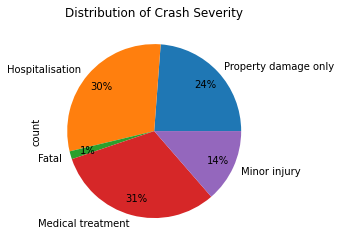

In [13]:
crash_severity_pd = crash_locations.groupBy('Crash_Severity').count().toPandas().set_index("Crash_Severity")

crash_severity_pd.plot.pie(autopct='%1.0f%%', pctdistance=0.8, radius=1, y="count", title="Distribution of Crash Severity", legend=None);

It can be seen that the majority of crashes require hospitalisation or medical treatment, with 1% being fatal.

### Crash Time

In [14]:
#Query to find count for each time-related column
crash_year_pd = spark.sql("""
SELECT Crash_Year as Year, COUNT(*) as Count
FROM Crashes
GROUP BY Year
ORDER BY Year
""").toPandas()

crash_month_pd = spark.sql("""
SELECT Crash_Month as Month, COUNT(*) as Count
FROM Crashes
GROUP BY Month
ORDER BY
    Case Month
        when "January" then 1
        when "February" then 2
        when "March" then 3
        when "April" then 4
        when "May" then 5
        when "June" then 6
        when "July" then 7
        when "August" then 8
        when "September" then 9
        when "October" then 10
        when "November" then 11
        when "December" then 12
    end
""").toPandas()

crash_day_pd = spark.sql("""
SELECT Crash_Day_Of_Week as Day, COUNT(*) as Count
FROM Crashes
GROUP BY Day
ORDER BY
    Case Day
        when "Monday" then 1
        when "Tuesday" then 2
        when "Wednesday" then 3
        when "Thursday" then 4
        when "Friday" then 5
        when "Saturday" then 6
        when "Sunday" then 7
    end
""").toPandas()

crash_hour_pd = spark.sql("""
SELECT Crash_Hour as Hour, COUNT(*) as Count
FROM Crashes
GROUP BY Hour
ORDER BY Hour
""").toPandas()

<AxesSubplot:title={'center':'Number of crashes each hour'}, xlabel='Hour'>

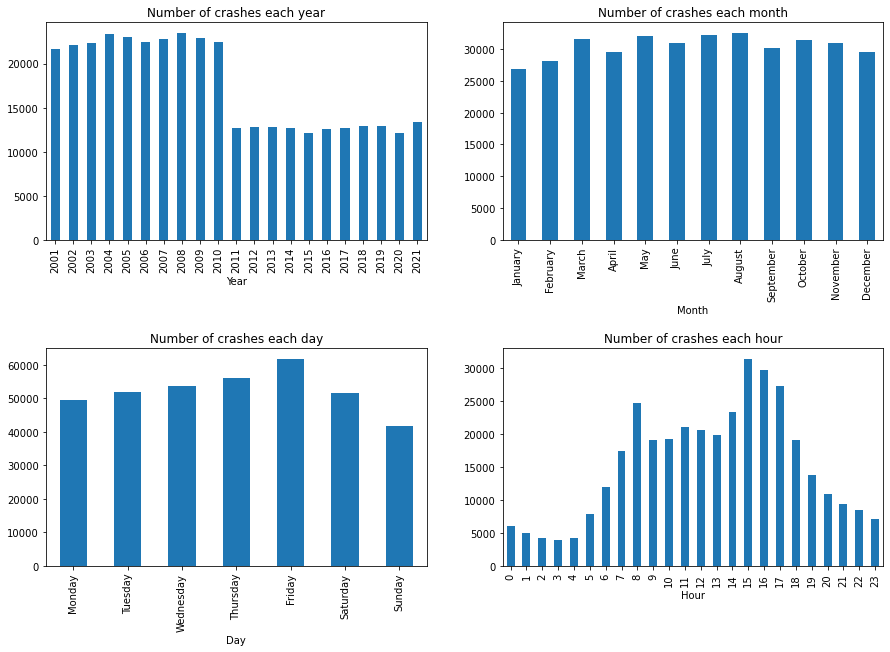

In [15]:
# plot queries
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

plt.subplots_adjust(hspace=0.5)

crash_year_pd.plot(ax=axes[0,0], kind='bar', x="Year", y="Count", title="Number of crashes each year", legend=None)
crash_month_pd.plot(ax=axes[0,1], kind='bar', x="Month", y="Count", title="Number of crashes each month", legend=None)
crash_day_pd.plot(ax=axes[1,0], kind='bar', x="Day", y="Count", title="Number of crashes each day", legend=None)
crash_hour_pd.plot(ax=axes[1,1], kind='bar', x="Hour", y="Count", title="Number of crashes each hour", legend=None)

After 2010, property damage only crashes were not recorded. This is why there were a lot less crashes in the following years. Otherwise the number of crashes each year is somewhat stable.

The number of crashes each month slightly increases towards the middle of the year and slightly decreases towards the end of the year.

The number of crashes each day increases as the week progresses and decreases during the weekend.

The number of crashes at each hour peaks during morning and afternoon commute.

### Crash Type and Nature

In [16]:
crash_type_pd = spark.sql("""
SELECT Crash_Type as Type, COUNT(*) as Count
FROM Crashes
GROUP BY Type
""").toPandas().set_index("Type")

crash_nature_pd = spark.sql("""
SELECT Crash_Nature as Nature, COUNT(*) as Count
FROM Crashes
GROUP BY Nature
ORDER BY Count DESC
""").toPandas()

<AxesSubplot:title={'center':'Number of crashes by Nature'}, xlabel='Nature'>

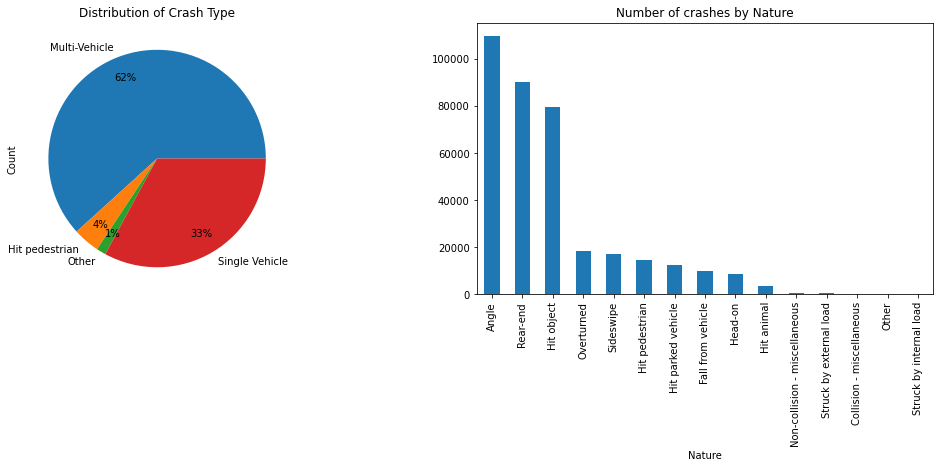

In [17]:
# plot queries
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))


crash_type_pd.plot(ax=axes[0], kind='pie', autopct='%1.0f%%', pctdistance=0.8, radius=1, y="Count",\
                       title="Distribution of Crash Type", legend=None);
crash_nature_pd.plot(ax=axes[1], kind='bar', x="Nature", y="Count", title="Number of crashes by Nature", legend=None)


The vast majority of crashes included either multiple-vehicles or a single vehicle.

Most crashes that occured were an angle, a rear-end or an object was hit.

### Crash Location

In [18]:
crash_suburb_pd = spark.sql("""
SELECT Loc_Suburb as Suburb, COUNT(*) as Count
FROM Crashes
GROUP BY Suburb
ORDER BY Count DESC
""").toPandas()

<AxesSubplot:title={'center':'Top 20 QLD suburbs with most crashes'}, xlabel='Suburb'>

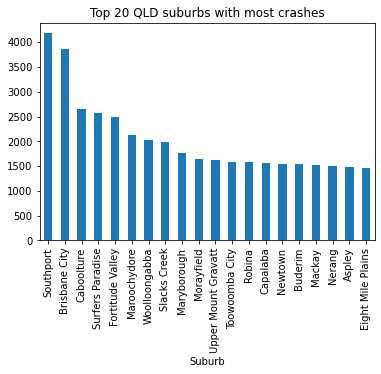

In [19]:
crash_suburb_pd.iloc[0:20].plot(kind='bar', x="Suburb", y="Count", title="Top 20 QLD suburbs with most crashes", legend=None)


The suburbs with the most crashes are Southport, Brisbane City andd Caboolture, with Southport having more than 4000 crashes.

### Crash Conditions

In [20]:
crash_roadway_pd = spark.sql("""
SELECT Crash_Roadway_Feature as Roadway_Feature, COUNT(*) as Count
FROM Crashes
GROUP BY Roadway_Feature
ORDER BY Count DESC
""").toPandas()

crash_speed_pd = spark.sql("""
SELECT Crash_Speed_Limit as Speed, COUNT(*) as Count
FROM Crashes
GROUP BY Speed
ORDER BY
    Case Speed
        when "0 - 50 km/h" then 1
        when "60 km/h" then 2
        when "70 km/h" then 3
        when "80 - 90 km/h" then 4
        when "100 - 110 km/h" then 5
    end
""").toPandas()

crash_atmosphere_pd = spark.sql("""
SELECT Crash_Atmospheric_Condition as Atmospheric_Condition, COUNT(*) as Count
FROM Crashes
GROUP BY Atmospheric_Condition
ORDER BY Count DESC
""").toPandas()

<AxesSubplot:title={'center':'Number of crashes by Weather'}, xlabel='Atmospheric_Condition'>

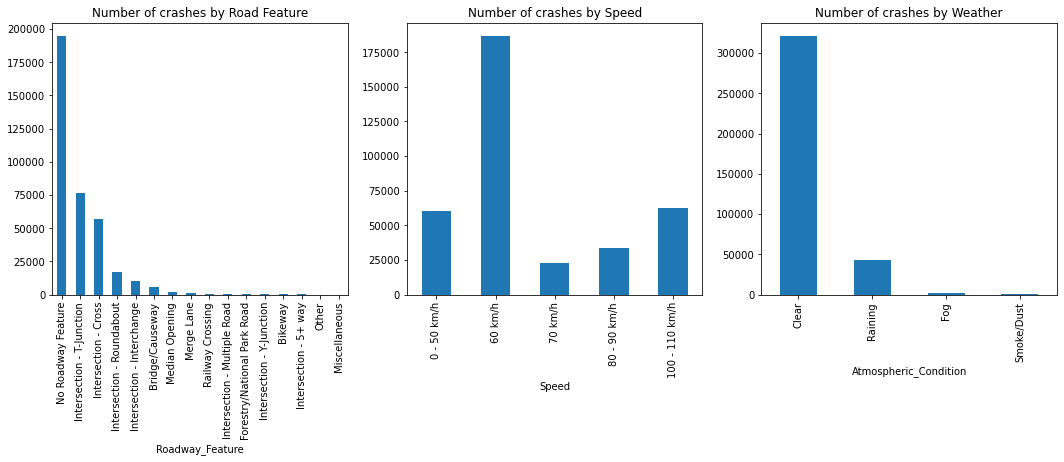

In [21]:
# plot queries
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

plt.subplots_adjust(hspace=0.5)

crash_roadway_pd.plot(ax=axes[0], kind='bar', x="Roadway_Feature", y="Count", title="Number of crashes by Road Feature", legend=None)
crash_speed_pd.plot(ax=axes[1], kind='bar', x="Speed", y="Count", title="Number of crashes by Speed", legend=None)
crash_atmosphere_pd.plot(ax=axes[2], kind='bar', x="Atmospheric_Condition", y="Count", title="Number of crashes by Weather", legend=None)


The majority of crashes occur with no particular roadway feature, with many occuring at a T junction, Cross or Roundabout intersection.

The majority of crashes happen with a speed limit of 60km/h

The majority of crashes happen during clear conditions, with some happenning in rainy conditions

### Crash Casualty Counts

In [22]:
# Create pandas df containing all casualties
casualty_col = [col for col in filtered_crash_loc.columns if col.startswith("Count_Casualty_")]
casualty_pd = spark.sql(f"""
SELECT {', '.join([f"{col} as {col[15:]}" for col in casualty_col])}
FROM Crashes
""").toPandas()


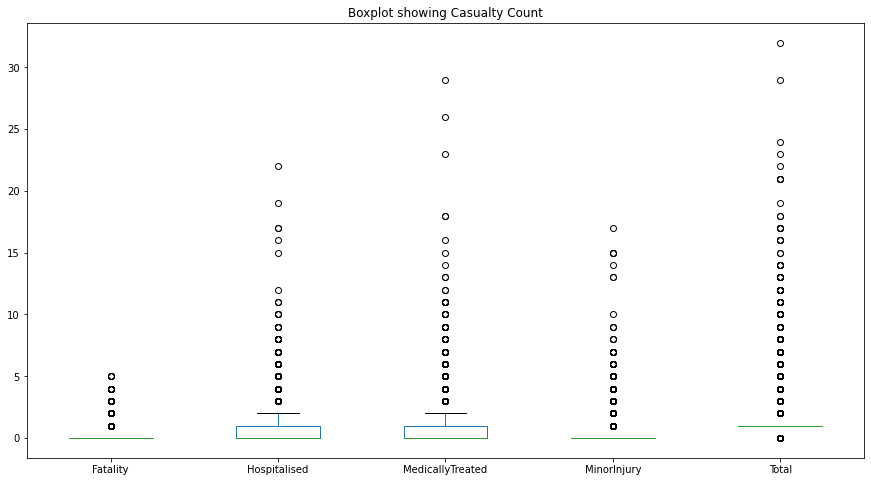

In [23]:
ax = casualty_pd[[col[15:] for col in casualty_col]].plot(kind='box', title='Boxplot showing Casualty Count', figsize=(15, 8))

plt.show()

It is evident that on average, casualties of all types are very low, with many outliers. Of all types of casualties, the boxplot suggests that most require medical treatment.

### Crash Unit Counts

In [24]:
# Create pandas df containing all unitd
unit_col = [col for col in filtered_crash_loc.columns if col.startswith("Count_Unit_")]
unit_pd = spark.sql(f"""
SELECT {', '.join([f"{col} as {col[11:]}" for col in unit_col])}
FROM Crashes
""").toPandas()

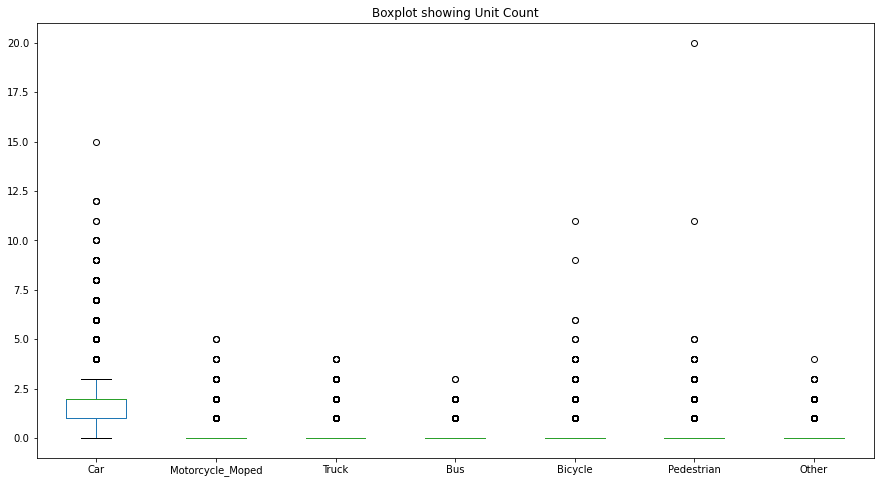

In [25]:
ax = unit_pd[[col[11:] for col in unit_col]].plot(kind='box', title='Boxplot showing Unit Count', figsize=(15, 8))

plt.show()

It is evident that the majority of crashes involve cars, while all other units only occur as an outlier.

## Further Analysis

In [42]:
# What is the most dangerous road fixture for Pedestrians / Cyclists / between years 2013 - 2019 excluding No Roadway Feature
cyclist_pd = spark.sql("""
SELECT Crash_Roadway_Feature as Roadway_Feature, SUM(Count_Unit_Bicycle) as SumBike, SUM(Count_Unit_Pedestrian) as SumPedestrian
FROM Crashes
WHERE NOT Crash_Roadway_Feature == "No Roadway Feature" AND
    Crash_Year BETWEEN 2013 AND 2019
GROUP BY Roadway_Feature
ORDER BY SumBike DESC
""").toPandas()
# Cumalative sum trend bsomething

<AxesSubplot:title={'center':'Number of Cyclists and Pedestrians involved in crashes by Road Feature (2013 -2019)'}, xlabel='Roadway_Feature'>

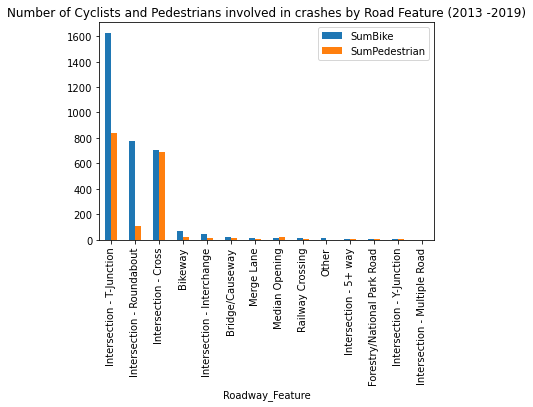

In [45]:
cyclist_pd.plot(kind='bar', x="Roadway_Feature", title="Number of Cyclists and Pedestrians involved in crashes by Road Feature (2013 -2019)")

It can be seen that at T-juntion and roundabout intersections, the number of cyclists involved in car crashes greatly outnumber the number of pedestrians. However at cross intersections, the number of cyclists and pedestrians are similar.

In [84]:
# Does the time of day correlate to speed limit when crashes occur?
crash_hour_pd = spark.sql("""
SELECT Crash_Hour as Hour,
    COUNT(CASE WHEN Crash_Speed_Limit = '0 - 50 km/h' THEN 1 END) as 0to50kmh,
    COUNT(CASE WHEN Crash_Speed_Limit = '60 km/h' THEN 1 END) as 60kmh,
    COUNT(CASE WHEN Crash_Speed_Limit = '70 km/h' THEN 1 END) as 70kmh,
    COUNT(CASE WHEN Crash_Speed_Limit = '80 - 90 km/h' THEN 1 END) as 80to90kmh,
    COUNT(CASE WHEN Crash_Speed_Limit = '100 - 110 km/h' THEN 1 END) as 100to110kmh
FROM Crashes
GROUP BY Hour
ORDER BY Hour
""").toPandas()

In [85]:
crash_hour_pd

,Hour,0to50kmh,60kmh,70kmh,80to90kmh,100to110kmh
0,0,1299,2636,347,576,1138
1,1,1090,2232,305,470,959
2,2,854,1789,245,378,925
3,3,711,1644,217,341,995
4,4,631,1613,248,471,1232
5,5,921,3358,478,909,2197
6,6,1646,5517,696,1418,2681
7,7,2693,8681,1100,1857,3174
8,8,4402,13220,1547,2265,3342
9,9,3115,10112,1169,1702,3051


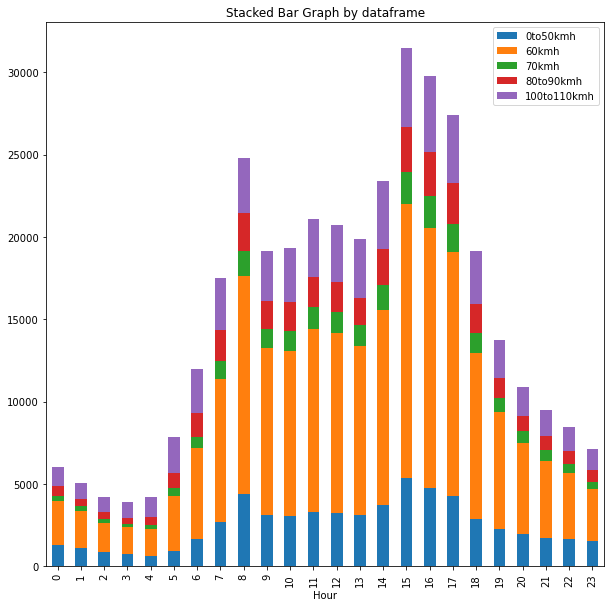

In [88]:
crash_hour_pd.plot(x='Hour', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe', figsize=(10, 10))
plt.show()

It is evident there is no correlation between the time of day, and the speed limit at which a crash is likely to occur. The graph clearly shows that 60km/h is the highest crash count for every hour.

In [177]:
# Suburb with the highest number of crashes for each year
crash_suburb_each_year_pd = spark.sql("""
SELECT Crash_Year,first(Loc_Suburb), MAX(count)
FROM (
    SELECT C2.Loc_Suburb, C2.Crash_Year, COUNT(*) as count
    FROM Crashes as C2
    GROUP BY C2.Loc_Suburb, C2.Crash_Year
    ORDER BY COUNT(*) DESC
)
GROUP BY Crash_Year
ORDER BY Crash_Year
""").toPandas()

In [178]:
crash_suburb_each_year_pd

,Crash_Year,first(Loc_Suburb),max(count)
0,2001,Brisbane City,298
1,2002,Brisbane City,332
2,2003,Brisbane City,278
3,2004,Southport,273
4,2005,Brisbane City,286
5,2006,Southport,234
6,2007,Southport,281
7,2008,Southport,233
8,2009,Southport,230
9,2010,Southport,246


For the majority of years, most crashes occur in Southport.

In [242]:
# Number of car crashes over the years (cumalative sum)
crash_sumalative_sum_pd = spark.sql("""
WITH C1 AS (
    SELECT Crash_Year, SUM(count) OVER(ORDER BY Crash_Year ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS single_vehicle
    FROM (SELECT Crash_Year, COUNT(*) as count FROM Crashes WHERE Crash_Type == "Single Vehicle" GROUP BY Crash_Year)
    ORDER BY Crash_Year
    ), C2 AS (
    SELECT Crash_Year, SUM(count) OVER(ORDER BY Crash_Year ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS multi_vehicle
    FROM (SELECT Crash_Year, COUNT(*) as count FROM Crashes WHERE Crash_Type == "Multi-Vehicle" GROUP BY Crash_Year)
    ORDER BY Crash_Year
    ), C3 AS (
    SELECT Crash_Year, SUM(count) OVER(ORDER BY Crash_Year ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS hit_pedestrian
    FROM (SELECT Crash_Year, COUNT(*) as count FROM Crashes WHERE Crash_Type == "Hit pedestrian" GROUP BY Crash_Year)
    ORDER BY Crash_Year
    ), C4 AS (
    SELECT Crash_Year, SUM(count) OVER(ORDER BY Crash_Year ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS other
    FROM (SELECT Crash_Year, COUNT(*) as count FROM Crashes WHERE Crash_Type == "Other" GROUP BY Crash_Year)
    ORDER BY Crash_Year
    )
SELECT C1.Crash_Year, C1.single_vehicle, C2.multi_vehicle, C3.hit_pedestrian, C4.other
FROM C1
INNER JOIN C2 ON C1.Crash_Year = C2.Crash_Year
INNER JOIN C3 ON C1.Crash_Year = C3.Crash_Year
INNER JOIN C4 ON C1.Crash_Year = C4.Crash_Year
""").toPandas()

In [243]:
crash_sumalative_sum_pd

,Crash_Year,single_vehicle,multi_vehicle,hit_pedestrian,other
0,2001,6920,13493,866,425
1,2002,14084,27169,1728,836
2,2003,21412,40938,2539,1213
3,2004,29266,55352,3305,1570
4,2005,37311,69262,4059,1911
5,2006,45287,82635,4816,2239
6,2007,53411,96255,5557,2573
7,2008,61847,110245,6322,2892
8,2009,70248,123658,7073,3261
9,2010,78225,137090,7829,3597


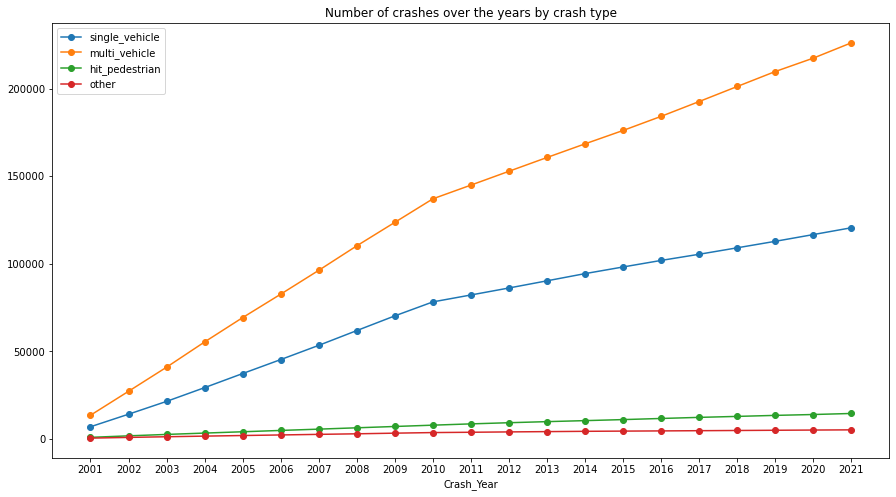

In [248]:
crash_sumalative_sum_pd.plot(kind='line', marker='o', x="Crash_Year", title="Number of crashes over the years by crash type", figsize=(15,8))
plt.xticks(range(2001, 2022))
plt.show()

It can be seen that over the years, multi-vehicle crashes are the most prominent type, followed by single vehicle and then hit pedestrian.